In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


References

In [2]:
anchor_genes = ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2']
replaceable = ['KIR2DS2', 'KIR2DS3', 'KIR2DP1', 'KIR2DL1', 'KIR3DS1', 'KIR2DS5', 'KIR2DS4']
dependent = ['KIR2DS1', 'KIR2DL3', 'KIR2DL2', 'KIR3DL1', 'KIR2DL5A', 'KIR2DL5B']

In [3]:
high_freq = ['KIR2DP1', 'KIR2DL1', 'KIR2DS4'] # 'KIR2DL5' 
low_freq = ['KIR2DS3', 'KIR2DS2',  'KIR2DS5', 'KIR3DS1']

In [4]:
random_genes = [x.strip() for x in open('/cellar/users/ramarty/Data/kir/kmers/reference_genes/random_genes.100.txt').readlines()]
len(random_genes)

9936

In [5]:
k=30

## Determining gene cutoffs from k-mer distribution information <br>
http://localhost:5004/notebooks/Projects/kir/kir_v0/typing/prediction_pipeline/TCGA/cutoff_optimization.ipynb

#### Get single value per gene from k-mers (would probably like to import this eventually)

In [6]:
# these are the good patients, would like to further restrict to only specific set of k-mers after optimization
df = pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/kir_four_random_counts.agilent.good_coverage.csv',
           index_col=0)

In [7]:
patients = list(df.index)

In [8]:
k

30

In [9]:
all_dfs = []
for i, gene in enumerate(anchor_genes + high_freq + low_freq):
    nonanchor = df[kmers[k][gene]].mean(axis=1)
    normalizer = df[random_genes].mean(axis=1)

    merged = pd.merge(pd.DataFrame(nonanchor), pd.DataFrame(normalizer), 
                      left_index=True, right_index=True).drop_duplicates()
    merged.columns = ['nonanchor', 'normalizer']
    merged[gene] = merged['nonanchor'] / merged['normalizer']

    all_dfs.append(merged[[gene]].transpose())

In [10]:
gene_values_df = pd.concat(all_dfs).transpose()

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [11]:
gene_values_df.head()

,KIR3DL3,KIR3DP1,KIR2DL4,KIR3DL2,KIR2DP1,KIR2DL1,KIR2DS4,KIR2DS3,KIR2DS2,KIR2DS5,KIR3DS1
TCGA-02-0003,5.444933,3.656040,4.655368,6.833107,2.644844,7.791039,5.546058,0.002928,0.000000,0.008251,0.000000
TCGA-02-0033,5.416096,1.762030,2.234819,6.426354,1.406267,3.897862,2.638110,0.009700,3.433759,2.816651,0.000000
TCGA-02-0047,5.878756,3.795708,4.768531,7.359189,1.508740,3.411130,5.415465,0.008244,3.596917,0.000334,0.000000
TCGA-02-0055,5.276827,3.586193,4.607362,6.448755,1.383465,3.646851,5.895592,0.002518,3.106109,0.001223,0.000000
TCGA-02-2470,5.068087,3.713773,4.227034,6.238302,2.643354,7.629105,3.059884,0.004701,0.000000,2.713178,0.719213


In [12]:
gene_values_df.to_csv('/cellar/users/ramarty/Data/kir/TCGA/data_frames/TCGA.patient_gene_values.random_mean.csv')

#### Get distributions

In [13]:
def return_cutoffs(gene, w):
    kernel = sp.gaussian_kde(w[gene])
    max_value = w[gene].max()
    a = kernel(np.arange(0, max_value, max_value/float(1000)))
    coverage_values = np.arange(0, max_value, max_value/float(1000))
    return list(coverage_values[np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]][1:4])

In [14]:
def return_cutoffs(gene, w, stringency, kind):
    kernel = sp.gaussian_kde(w[gene])
    max_value = w[gene].max()
    a = kernel(np.arange(0, max_value, max_value/float(1000)))
    coverage_values = np.arange(0, max_value, max_value/float(1000))
    derivative_a = np.gradient(a)
    lows, highs = [], []
    lows_v, highs_v = [], []
    for i, value in enumerate(derivative_a[:]):
        # get mins
        
        if (abs(value) > stringency) & (derivative_a[i] < 0) & ((derivative_a[i-1] > 0) or (i == 0)):
            highs.append(i)
            highs_v.append(coverage_values[i])
            #plt.axvline(x=coverage_values[i], ymin=0, ymax=1, linewidth=2, color='k')
        # get maxs
        if (i != 0) & (abs(value) > stringency) & (derivative_a[i] > 0) & ((derivative_a[i-1] < 0)):
            #plt.axvline(x=coverage_values[i], ymin=0, ymax=1, linewidth=2, color='r')
            lows.append(i)
            lows_v.append(coverage_values[i])

    print highs_v
            
    # do I need another category that is 
    if kind == 'low_freq':
        
        # get the location of the second peak, get the leveling off
        last_peak = highs[1]
        for i, value in enumerate(derivative_a[last_peak:]):
            index = len(derivative_a[:last_peak]) + i
            # get half the height and derivative that is less than x
            if a[index] < float(a[last_peak])/10 and value > -0.05:
                post = index
                break                    
        post_post = post - lows[0] 
        lows = lows[:1] + [post] + [post + post_post]

        coverage_lows = [coverage_values[x] for x in lows]


    elif kind == 'high_freq':
        # get the location of the third peak, get the leveling off
        last_peak = highs[2]
        for i, value in enumerate(derivative_a[last_peak:]):
            index = len(derivative_a[:last_peak]) + i
            # get half the height and derivative that is less than x
            if a[index] < float(a[last_peak])/10 and value > -0.1:
                post = index
                break        
        lows = lows[:2] + [post] 

        coverage_lows = [coverage_values[x] for x in lows]

    else: #anchors
        # find highest peak
        if len(highs) > 1:
            heights_of_maxs = [a[x] for x in highs]
            heights_index = [a[x] for x in highs].index(max(heights_of_maxs))
            heighest = highs[heights_index]
        else:
            heighest = highs[0]
        

        # find region that levels out (derivative goes close to zero) - start by going backward
        reversed_list = derivative_a[:heighest][::-1]
        for i, value in enumerate(reversed_list):
            index = len(reversed_list) - i
            # get half the height and derivative that is less than x
            if a[index] < float(a[heighest])/10 and value < 0.1:
                pre = index
                break

        # find the post region
        for i, value in enumerate(derivative_a[heighest:]):
            index = len(derivative_a[:heighest]) + i
            # get half the height and derivative that is less than x
            if a[index] < float(a[heighest])/10 and value > -0.1:
                post = index
                break

        # measure that width to go backward
        pre_pre = pre - (post-pre)
        #pre_pre = pre - 2*(heighest - pre)
        if pre_pre < 0:
            coverage_lows = [coverage_values[i] for i in [0, pre, post]]
        else:
            coverage_lows = [coverage_values[i] for i in [pre_pre, pre, post]]
    return coverage_lows, highs_v

In [15]:
gene_peaks, gene_cutoffs = {}, {}

for gene in high_freq:
    print gene
    gene_cutoffs[gene], gene_peaks[gene] = return_cutoffs(gene, gene_values_df.dropna(), 0.000001, 'high_freq')
for gene in low_freq:
    print gene
    gene_cutoffs[gene], gene_peaks[gene] = return_cutoffs(gene, gene_values_df.dropna(), 0.0000005, 'low_freq')
for gene in anchor_genes:
    print gene
    gene_cutoffs[gene], gene_peaks[gene] = return_cutoffs(gene, gene_values_df.dropna(), 0.00001, 'anchor')

KIR2DP1
[0.07842503235007266, 1.548894388913935, 2.9017261969526884, 5.274083425542386, 8.724784848945584, 11.548086013548199, 13.096980402462133]
KIR2DL1
[0.049290384913196324, 3.943230793055706, 7.738590431371823]
KIR2DS4
[0.031314046720719274, 2.9122063450268927, 5.667842456450189, 10.834660165368868, 12.588246781729149, 18.60054375210725]
KIR2DS3
[0.0, 4.0826414850362855, 7.773796800274571, 15.323887217807428, 18.73540955461857, 26.229573376466]
KIR2DS2
[0.0, 3.06533439796372, 14.620983495323356, 16.38520473156147, 18.105320436893628]
KIR2DS5
[0.0, 2.940099154232814, 5.6964421113260775, 10.71036120470525, 12.337916093655558, 13.807965670771965]
KIR3DS1
[0.0, 0.6416027696263468, 1.3135516161944802, 2.1935878475062935, 3.810600233118641]
KIR3DL3
[5.345852339061962]
KIR3DP1
[1.941874768774874, 3.7084413987020164, 7.0932370026082205]
KIR2DL4
[2.210765511027397, 4.277741395321305, 7.369218370091324]
KIR3DL2
[6.2003615813996396]


In [16]:
gene_cutoffs

{'KIR2DL1': [1.380130777569497, 5.471232725364792, 10.99175583564278],
 'KIR2DL4': [0.26960555012529236, 3.1633717881367636, 6.057138026148235],
 'KIR2DP1': [0.588187742625545, 2.0978696153644436, 4.254558004991441],
 'KIR2DS2': [1.3893242235375136, 7.387676426747095, 13.386028629956678],
 'KIR2DS3': [2.0133574446754285, 10.290493606118858, 18.567629767562284],
 'KIR2DS4': [1.1899337753873325, 4.196082260576382, 7.797197633459099],
 'KIR2DS5': [1.2337916093655559, 4.698908469711372, 8.16402533005719],
 'KIR3DL2': [0.0, 4.256464436960834, 9.518392914148636],
 'KIR3DL3': [0.4582159147767396, 3.8621055674039484, 7.265995220031157],
 'KIR3DP1': [0.0, 2.7914449801138814, 5.609860443127414],
 'KIR3DS1': [0.27311469247608006, 1.5216390009381602, 2.7701633094002402]}

In [17]:
pickle.dump(gene_cutoffs, open('/cellar/users/ramarty/Data/kir/TCGA/cutoffs/random_mean.p', 'w'))

### Make visualization of peaks and cutoffs <br>
Figure 5

In [16]:
def plot_gene_distributions(df_kir, gene_set):
    # gene_set = anchor_genes
    palette = sns.color_palette("hls", len(gene_set))

    df_kir_tmp = df_kir.loc[patients].dropna()
    f, axarr = plt.subplots(3, sharex=True, figsize=(6, 12))

    print len(patients), len(df_kir_tmp)

    for i, gene in enumerate(gene_set):
        nonanchor = df_kir_tmp[kmers[k][gene]].mean(axis=1)
        normalizer = df_kir_tmp[random_genes].mean(axis=1)

        merged = pd.merge(pd.DataFrame(nonanchor), pd.DataFrame(normalizer), left_index=True, right_index=True).drop_duplicates()
        merged.columns = ['nonanchor', 'normalizer']
        merged['normalized'] = merged['nonanchor'] / merged['normalizer']

        minimum, maximum = merged['normalized'].min(), merged['normalized'].max()

        plt.subplot(len(gene_set), 1, i+1)
        merged['normalized'].hist(bins=100, color='darkgrey', density=True)
        list_normalized = merged['normalized'][:, np.newaxis]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(list_normalized)
        X_plot = np.linspace(minimum, maximum, 100)[:, np.newaxis]
        log_dens = kde.score_samples(X_plot)
        plot(X_plot[:, 0], np.exp(log_dens), '-')
        plt.xlim(0, maximum)
        plt.ylabel(gene)
        try:
            for peak in gene_peaks[gene]:
                plt.axvline(peak, color='r')
            for cutoff in gene_cutoffs[gene]:
                plt.axvline(cutoff, color='y')
        except:
            print gene

4717 4717


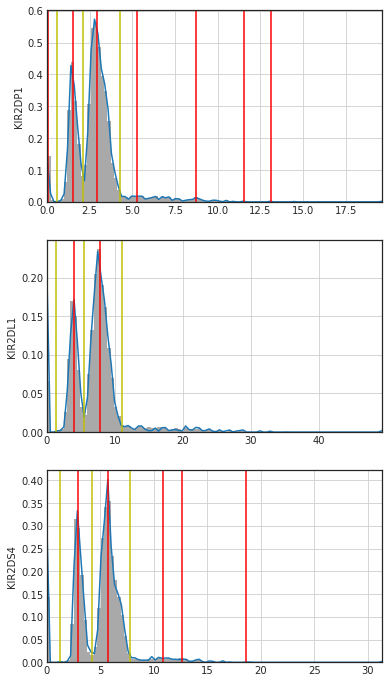

In [17]:
plot_gene_distributions(df, high_freq)

4717 4717


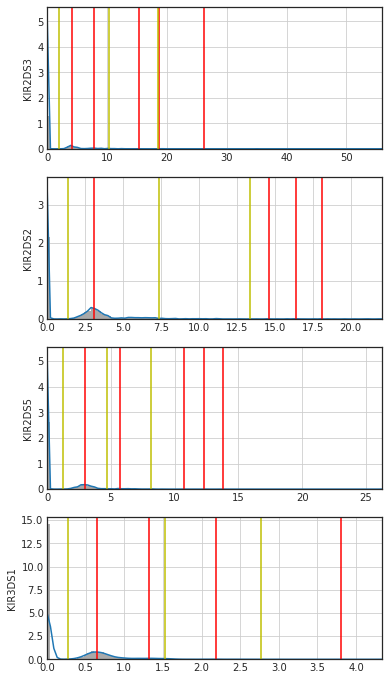

In [18]:
plot_gene_distributions(df, low_freq)

4717 4717


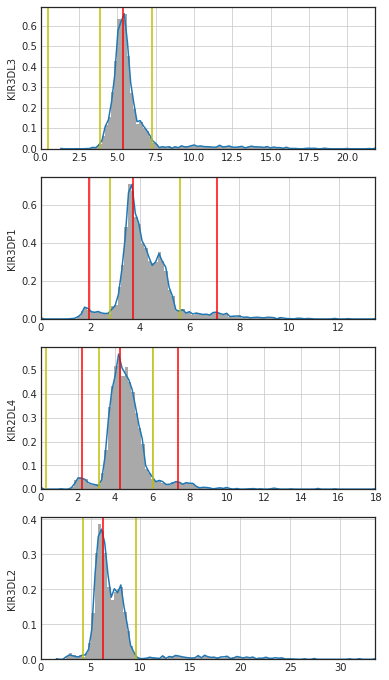

In [19]:
plot_gene_distributions(df, anchor_genes)

### Make a single figure

None
4717 4717


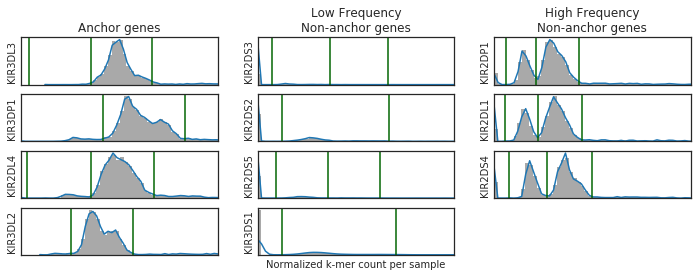

In [22]:
gene_set = []
i=0
for x in zip(anchor_genes, high_freq+[''], low_freq):
    gene_set.append(anchor_genes[i])
    gene_set.append(low_freq[i])
    try:
        gene_set.append(high_freq[i])
    except:
        print None
    i += 1
    
palette = sns.color_palette("hls", len(gene_set))


df = df.dropna()
f, axarr = plt.subplots(4, 3, figsize=(12, 4))

print len(patients), len(df)

for i, gene in enumerate(gene_set):
    nonanchor = df[kmers[k][gene]].mean(axis=1)
    normalizer = df[random_genes].mean(axis=1)

    merged = pd.merge(pd.DataFrame(nonanchor), pd.DataFrame(normalizer), left_index=True, right_index=True).drop_duplicates()
    merged.columns = ['nonanchor', 'normalizer']
    merged['normalized'] = merged['nonanchor'] / merged['normalizer']

    minimum, maximum = merged['normalized'].min(), merged['normalized'].max()

    plt.subplot(4, 3, i+1)
    merged['normalized'].hist(bins=100, color='darkgrey', density=True)
    list_normalized = merged['normalized'][:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(list_normalized)
    X_plot = np.linspace(minimum, maximum, 100)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    plot(X_plot[:, 0], np.exp(log_dens), '-')
    plt.xlim(0, maximum/2)
    plt.ylabel(gene)
    plt.xticks([])
    plt.yticks([])

    #for peak in gene_peaks[gene]:
    #    plt.axvline(peak, color='r')
    for cutoff in gene_cutoffs[gene]:
        plt.axvline(cutoff, color='darkgreen')

    if i == 0:
        plt.title("Anchor genes")
    if i == 1:
        plt.title("Low Frequency\nNon-anchor genes")
    if i == 2:
        plt.title("High Frequency\nNon-anchor genes")
        
    if i == 10:
        plt.xlabel('Normalized k-mer count per sample')
    
f.delaxes(axarr[3][2])
plt.savefig('/cellar/users/ramarty/Data/kir/manuscript_figures/figure_3.pdf', bbox_inches='tight')

In [ ]:
axarr[3][2

In [ ]:
f.delaxes()

In [49]:
# shading this figure would improve the quality. Use same blue colors as for frequency

In [47]:
gene_set

['KIR3DL3',
 'KIR2DS3',
 'KIR2DP1',
 'KIR3DP1',
 'KIR2DS2',
 'KIR2DL1',
 'KIR2DL4',
 'KIR2DS5',
 'KIR2DS4']

In [49]:
anchor_genes

['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2']

In [50]:
low_freq

['KIR2DS3', 'KIR2DS2', 'KIR2DS5', 'KIR3DS1']

In [52]:
high_freq + ['']

['KIR2DP1', 'KIR2DL1', 'KIR2DS4', '']

### Debugging

In [189]:
genes_with_problems = ['KIR2DL5']

In [197]:
w = gene_values_df.dropna()
#gene = 'KIR2DS4' # why are these genes behaving differently??
#gene = 'KIR2DL1' # stringency = 0.000001
gene = high_freq[1]
print gene
stringency = 0.000001

KIR2DL1


In [198]:
kernel = sp.gaussian_kde(w[gene])
max_value = w[gene].max()
a = kernel(np.arange(0, max_value, max_value/float(1000)))
coverage_values = np.arange(0, max_value, max_value/float(1000))
derivative_a = np.gradient(a)
lows, highs = [], []
lows_v, highs_v = [], []
for i, value in enumerate(derivative_a[:]):
    # get mins
    if (abs(value) > stringency) & (derivative_a[i] < 0) & ((derivative_a[i-1] > 0) or (value == 0)):
        highs.append(i)
        highs_v.append(coverage_values[i])
        #plt.axvline(x=coverage_values[i], ymin=0, ymax=1, linewidth=2, color='k')
    # get maxs
    if (i != 0) & (abs(value) > stringency) & (derivative_a[i] > 0) & ((derivative_a[i-1] < 0)):
        #plt.axvline(x=coverage_values[i], ymin=0, ymax=1, linewidth=2, color='r')
        lows.append(i)
        lows_v.append(coverage_values[i])

In [199]:
highs_v

[0.060480479286617365, 4.656996905069537, 9.253513330852456, 26.67189136539826]

In [169]:
if len(highs) > 1:
    heights_of_maxs = [a[x] for x in highs]
    heights_index = [a[x] for x in highs].index(max(heights_of_maxs))
    heighest = highs[heights_index]
else:
    heighest = highs[0]

# find region that levels out (derivative goes close to zero) - start by going backward
reversed_list = derivative_a[:heighest][::-1]
for i, value in enumerate(reversed_list):
    index = len(reversed_list) - i
    # get half the height and derivative that is less than x
    if a[index] < float(a[heighest])/2 and value < 0.1:
        pre = index
        break

# find the post region
for i, value in enumerate(derivative_a[heighest:]):
    index = len(derivative_a[:heighest]) + i
    # get half the height and derivative that is less than x
    if a[index] < float(a[heighest])/2 and value > -0.1:
        post = index
        break

# measure that width to go backward
pre_pre = pre - (post-pre)
coverage_lows = [coverage_values[i] for i in [pre_pre, pre, post]]

In [66]:
coverage_values

array([0.00000000e+00, 1.92339585e-02, 3.84679169e-02, ...,
       1.91954906e+01, 1.92147245e+01, 1.92339585e+01])